# Axo ID tests
Notebook used to test detection and tracking together to start the work for AxoID.  
Workflow:
   1. Detection:
      1. Predict using deep network (generate detections)
      2. Decide if results are good:
         * Yes: continue to 2.
         * No: continue to 1.C
      3. Make manual annotations (to be done externally to this notebook)
      4. Fine tune the deep network (i.e., retrain it with manual annotations)
      5. Go to 1.B
   2. User correction (optional) (to be done externally to this notebook)
   3. Tracking:
      1. Select an initialization frame
      2. Track axons:
         * Train model
         * Generate final identities
   4. User correction (optional) (to be done externally to this notebook)

In [1]:
%matplotlib inline

import os, sys, time, shutil, copy, time
import random
import ipywidgets as widgets
from ipywidgets import interact

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage import io, external, measure, morphology
from scipy import ndimage as ndi
import cv2
import imgaug.augmenters as iaa

import torch

from utils_common.image import imread_to_float, to_npint, overlay_preds_targets
from utils_common.metrics import dice_coef
from utils_common.register_cc import register_stack, shift_image
# Following are copy-pasted from other folders. Check that they are up-to-date
from utils_data import normalize_range, get_all_dataloaders, pad_transform, pad_transform_stack, compute_weights
from utils_finetuning import fine_tune, ROIAnnotator_mpl
from utils_loss import get_BCEWithLogits_loss
from utils_metric import get_dice_metric
from utils_model import CustomUNet, load_model
from utils_test import predict, predict_stack, evaluate, evaluate_stack
from internal_model import InternalModel

seed = 1
random.seed(seed)
np.random.seed(seed*10 + 1234)
torch.manual_seed(seed*100 + 4321)

# Use GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

%load_ext autoreload
%autoreload 2

Device: cuda:0


interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

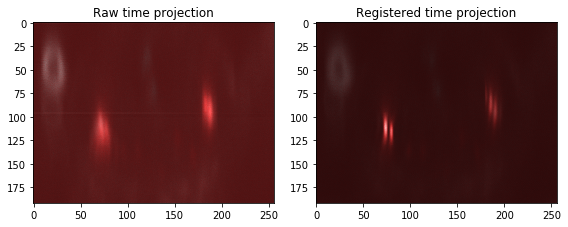

In [48]:
# Load experiment
experiment = "/data/talabot/experiments/annotated/SS28596_20190228_tdTomGC6fopt-fly2/SS28596_20190228_tdTomGC6fopt-fly2_001/"

rgb_stack = imread_to_float(os.path.join(experiment, "RGB.tif"))
if os.path.isfile(os.path.join(experiment, "seg_ROI.tif")):
    seg_stack = imread_to_float(os.path.join(experiment, "seg_ROI.tif"))
else:
    seg_stack = None
if os.path.isfile(os.path.join(experiment, "weights.tif")):
    weights_stack = imread_to_float(os.path.join(experiment, "weights.tif"))
else:
    weights_stack = None

@interact(image=(0, len(rgb_stack) - 1))
def plot_experiment(image=0):
    plt.figure(figsize=(12, 4))
    plt.suptitle(experiment)
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    if seg_stack is not None:
        plt.subplot(132)
        plt.title("Binary detection")
        plt.imshow(seg_stack[image], cmap="gray")
    if weights_stack is not None:
        plt.subplot(133)
        plt.title("Pixel weighting")
        plt.imshow(weights_stack[image], cmap="gray")
    plt.tight_layout()
    plt.show()

# Compute registration through cross-correlation
reg_rgb, reg_rows, reg_cols = register_stack(rgb_stack, ref_num=1, return_shifts=True)
reg_rgb = reg_rgb.clip(0, 1)
if seg_stack is not None:
    reg_seg = np.zeros_like(seg_stack)
    for i in range(len(reg_seg)):
        reg_seg[i] = shift_image(seg_stack[i], reg_rows[i], reg_cols[i])
    reg_seg = reg_seg.clip(0, 1)
else:
    reg_seg = None

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.title("Raw time projection")
plt.imshow(rgb_stack.mean(0) / rgb_stack.mean(0).max())
plt.subplot(122)
plt.title("Registered time projection")
plt.imshow(reg_rgb.mean(0) / reg_rgb.mean(0).max())
plt.tight_layout()
plt.show()

# 1. Detection
Detect ROIs on the frames as a binary segmentation

### A. Prediction
Load a model and predict over the experiments

In [24]:
model_name = "../detection/deep_learning/models/190401_sep_synth_aug/"
out_model_name = "../detection/deep_learning/models/test_axoid"

batch_size = 16

# Load model
input_channels = "RG" # Channels to use as input
u_depth = 4
out1_channels = 16
model = load_model(model_name, input_channels=input_channels, u_depth=u_depth, 
                   out1_channels=out1_channels, device=device)
metrics = {"dice": get_dice_metric()}
input_transform = lambda stack: normalize_range(pad_transform_stack(stack, u_depth))
# Save future model
os.makedirs(out_model_name, exist_ok=True)
shutil.copy("utils_model.py", os.path.join(out_model_name, "utils_model_save.py"))
model_ft = copy.deepcopy(model)

Predicted experiment in 2.5 s.
Dice = 0.908610115417078


interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

Computation of #ROIs took 0.1 s.
Argmax: 19 - argmin: 148


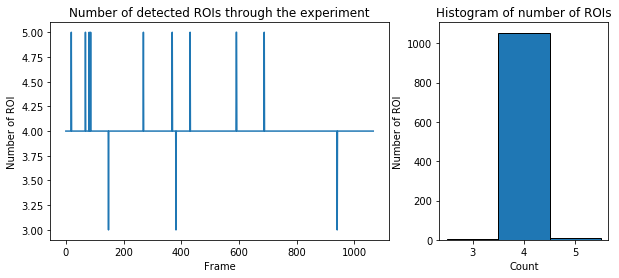

In [45]:
# Predict and display results
start = time.time()
predictions = predict_stack(model_ft, rgb_stack, batch_size, input_channels=input_channels,
                            transform=input_transform)
predictions = torch.sigmoid(predictions)

detections = (predictions > 0.5).numpy().astype(np.bool)
for i in range(len(detections)):
    detections[i] = morphology.remove_small_objects(detections[i], 16)
    
print("Predicted experiment in %.1f s." % (time.time() - start))
if seg_stack is not None:
    print("Dice =", dice_coef(detections, seg_stack))

@interact(image=(0, len(rgb_stack) - 1))
def plot_experiment(image=0):
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(132)
    plt.title("Prediction")
    plt.imshow(predictions[image], cmap="gray")
    plt.subplot(133)
    if seg_stack is not None:
        plt.title("Overlay with ground truth")
        plt.imshow(overlay_preds_targets(detections[image], seg_stack[image]))
    else:
        plt.title("Binary prediction")
        plt.imshow(detections)
    plt.tight_layout()
    plt.show()

start = time.time()
n_roi = np.zeros(len(rgb_stack), np.uint8)
for i in range(len(detections)):
    _, n = measure.label(detections[i], connectivity=1, return_num=True)
    n_roi[i] = n
print("Computation of #ROIs took %.1f s." % (time.time() - start))
print("Argmax:", np.argmax(n_roi), "- argmin:", np.argmin(n_roi))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), gridspec_kw={'width_ratios': [2, 1]})
ax1.set_title("Number of detected ROIs through the experiment")
ax1.plot(n_roi)
ax1.set_xlabel("Frame")
ax1.set_ylabel("Number of ROI")
ax2.set_title("Histogram of number of ROIs")
ax2.hist(n_roi, bins=np.arange(n_roi.min(), n_roi.max() + 2), align='left', edgecolor='k')
ax2.set_xticks(np.arange(n_roi.min(), n_roi.max() + 1))
ax2.set_xlabel("Count")
ax2.set_ylabel("Number of ROI")
plt.show()

### C Manual annotation
Create some manual annotations (outside this notebook), and fine tune the network with them.

In [12]:
# Select and annotated frames
n_train = 3 # number of frames to annotated for training
n_valid = 2 # number of frames to annotated for validation

# Randomly choose frames
indices = np.random.choice(np.arange(len(rgb_stack)), size=n_train + n_valid, replace=False)
idx_train = indices[:n_train]
idx_valid = indices[n_train:]
print("Indices of annotated frames:", idx_train, idx_valid, sep="\n")
rgb_train = np.stack([rgb_stack[idx] for idx in idx_train])
rgb_valid = np.stack([rgb_stack[idx] for idx in idx_valid])

Indices of annotated frames:
[1022  761  398]
[ 86 784]


In [13]:
# Load manual annotations
seg_annotated = external.tifffile.imread("/home/user/talabot/workdir/annotations.tif") / 255
seg_train = seg_annotated[:n_train]
seg_valid = seg_annotated[n_train:]

In [39]:
# Manually add indices for annotation if annotation was not good enough
new_idx_train = [20, 21]
new_idx_valid = [902]

# Randomly choose frames
print("Indices of new annotated frames:", new_idx_train, new_idx_valid, sep="\n")
new_rgb_train = np.stack([rgb_stack[idx] for idx in new_idx_train])
new_rgb_valid = np.stack([rgb_stack[idx] for idx in new_idx_valid])

Indices of new annotated frames:
[20, 21]
[902]


In [40]:
# Load new manual annotations
new_seg_annotated = external.tifffile.imread("/home/user/talabot/workdir/annotations.tif") / 255
new_seg_train = new_seg_annotated[:len(new_idx_train)]
new_seg_valid = new_seg_annotated[len(new_idx_train):]

In [41]:
# Concatenate previous and new annotations
idx_train = np.concatenate([idx_train, new_idx_train])
idx_valid = np.concatenate([idx_valid, new_idx_valid])
rgb_train = np.concatenate([rgb_train, new_rgb_train])
rgb_valid = np.concatenate([rgb_valid, new_rgb_valid])
seg_train = np.concatenate([seg_train, new_seg_train])
seg_valid = np.concatenate([seg_valid, new_seg_valid])
print("Indices of annotated frames:", idx_train, idx_valid, sep="\n")

Indices of annotated frames:
[1022  761  398  251  144   20   21]
[ 86 784 999   0 902]


### D. Fine tune the network

In [42]:
learning_rate = 0.0005
contour, separation = False, True

seg_train = seg_train.astype(rgb_train.dtype)
seg_valid = seg_valid.astype(rgb_valid.dtype)
weights_train = compute_weights(seg_train, contour=contour, separation=separation)
weights_valid = compute_weights(seg_valid, contour=contour, separation=separation)

@interact(image=(0, len(weights_train) + len(weights_valid) - 1))
def plot_experiment(image=0):
    if image < len(weights_train):
        rgb = rgb_train
        seg = seg_train
        wgt = weights_train
    else:
        rgb = rgb_valid
        seg = seg_valid
        wgt = weights_valid
    image %= len(weights_train)
    plt.figure(figsize=(12, 4))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb[image])
    plt.subplot(132)
    plt.title("Binary detection")
    plt.imshow(seg[image], cmap="gray")
    plt.subplot(133)
    plt.title("Pixel weighting")
    plt.imshow(wgt[image], vmax=max(wgt[image].max(), 0.1))
    plt.colorbar(fraction=0.035, pad=0.02)
    plt.tight_layout()
    plt.show()

start = time.time()
model_ft = fine_tune(model_ft, rgb_train, seg_train, weights_train, rgb_valid, seg_valid, 
                     data_aug=True, n_iter_max=1000, patience=200,
                     batch_size=batch_size, learning_rate = learning_rate, verbose=1)
print("\nFine tuning took %.1f s." % (time.time() - start))

interactive(children=(IntSlider(value=0, description='image', max=11), Output()), _dom_classes=('widget-intera…

Initial val_dice = 0.855548
Iteration (max 1000): 
50: dice = 0.916036 - val_dice = 0.841922
100: dice = 0.945133 - val_dice = 0.832896
150: dice = 0.964330 - val_dice = 0.835810
200: dice = 0.964830 - val_dice = 0.830829
250: dice = 0.973481 - val_dice = 0.834720
200 iterations without validation improvements. Fine tuning is interrupted at iteration 291.
Best model fine tuned in iteration 91.

Fine tuning took 16.2 s.


# 2. User correction (optional)

In [ ]:
# TODO

# 3. Tracking

Updating model took 20 s.
Identity matching took 4 s.


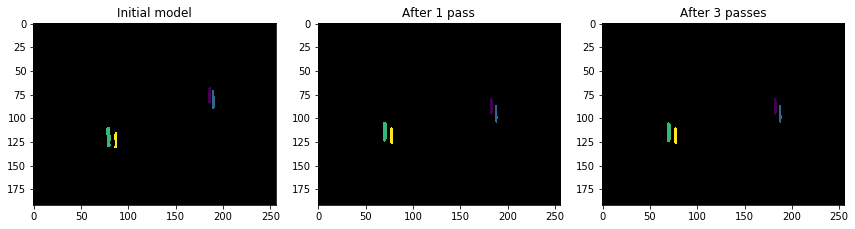

interactive(children=(IntSlider(value=0, description='image', max=1066), Output()), _dom_classes=('widget-inte…

In [52]:
init_idx = 0
n_updates = 3

id_cmap = matplotlib.cm.get_cmap('viridis')
id_cmap.set_under([0,0,0])

start = time.time()
# Initialization
model = InternalModel()
identities = np.zeros(detections.shape, np.uint8)
plt.figure(figsize=(12,4))
model.initialize(rgb_stack[init_idx], measure.label(detections[init_idx], connectivity=1))
plt.subplot(131)
plt.title("Initial model")
plt.imshow(model.image, cmap=id_cmap, vmin=1)

# Iterate n_updates times through the frames to udpate the model
for n in range(n_updates):
    for i in range(len(seg_stack)):
        identities[i] = model.match_frame(rgb_stack[i], detections[i], time_idx=i)
        model.update(rgb_stack[i], identities[i], time_idx=i)
    if n == 0:
        plt.subplot(132)
        plt.title("After 1 pass")
        plt.imshow(model.image, cmap=id_cmap, vmin=1)
print("Updating model took %d s." % (time.time() - start))

start = time.time()
# Iterate a final time to finalize the identities (without updating the model)
for i in range(len(seg_stack)):
    identities[i] = model.match_frame(rgb_stack[i], detections[i], time_idx=i)
print("Identity matching took %d s." % (time.time() - start))
plt.subplot(133)
plt.title("After %d passes" % n_updates)
plt.imshow(model.image, cmap=id_cmap, vmin=1)
plt.tight_layout()
plt.show()

# Display resulting identities
@interact(image = (0, len(identities) - 1))
def plot_data(image=0):
    plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(132)
    plt.title("Binary detection")
    plt.imshow(detections[image], cmap='gray')
    plt.subplot(133)
    plt.title("Identities")
    plt.imshow(identities[image], cmap=id_cmap, vmin=1, vmax=max([axon.id for axon in model.axons]))
    plt.tight_layout()
    plt.show()

**Error detection**  
Detect tracking errors through some metrics/infos/etc.

Argmax: 0 - argmin: 148


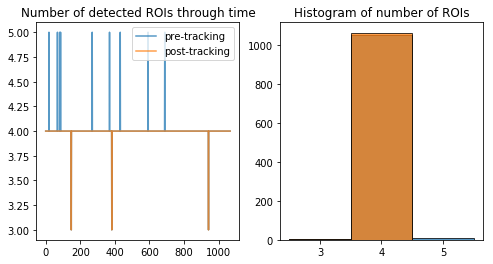

In [56]:
# Plot number of detected ROIs along time
n_roi_id = np.zeros(len(identities))
for i in range(len(n_roi)):
    n_roi_id[i] = measure.label(identities[i].astype(seg_stack.dtype), connectivity=1, return_num=True)[1]
#     if n_roi_id[i] < 4:
#         print(i)
print("Argmax:", np.argmax(n_roi_id), "- argmin:", np.argmin(n_roi_id))

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title("Number of detected ROIs through time")
plt.plot(n_roi, alpha=0.75)
plt.plot(n_roi_id, alpha=0.75)
plt.legend(["pre-tracking", "post-tracking"])
plt.subplot(122)
plt.title("Histogram of number of ROIs")
plt.hist(n_roi, bins=np.arange(n_roi.min(), n_roi.max() + 2), align='left', edgecolor='k', alpha=0.75)
plt.hist(n_roi_id, bins=np.arange(n_roi_id.min(), n_roi_id.max() + 2), align='left', edgecolor='k', alpha=0.75)
plt.xticks(np.arange(n_roi_id.min(), n_roi.max() + 1))
plt.show()

# 4. User correction (optional)

In [ ]:
# TODO